# 模型

本章我们将会讨论如何建立一个模型。首先我们会按前两章所述，简要的讲解一下数据读入和预处理。虽然我们将着重讨论建模的过程，以及建模中一些实践经验。

## 读取和预处理数据

### 读取数据

我们可以使用`pandas`库中的`read_excel`方法来读取数据。

In [1]:
import pandas as pd

data = pd.read_excel('data/pfm_data.xlsx')
data.head()

,EmployeeNumber,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,Over18,OverTime,StandardHours,TotalWorkingYears,YearsAtCompany,Attrition
0,77,37,Travel_Rarely,Research & Development,1,4,Life Sciences,Male,3,5993,1,Y,No,80,7,7,0
1,1245,54,Travel_Frequently,Research & Development,1,4,Life Sciences,Female,3,10502,7,Y,No,80,33,5,0
2,147,34,Travel_Frequently,Research & Development,7,3,Life Sciences,Male,3,6074,1,Y,Yes,80,9,9,1
3,1026,39,Travel_Rarely,Research & Development,1,1,Life Sciences,Female,4,12742,1,Y,No,80,21,21,0
4,1111,28,Travel_Frequently,Research & Development,1,3,Medical,Male,2,2596,1,Y,No,80,1,1,1


### 切分数据集

接下来，我们将数据集切分为训练集与测试集。`scikit-learn`的`model_selection`模块中提供了`train_test_split`方法，我们可以通过`test_size`参数设置一个作为测试集数据的百分比，而`stratify`一般设置为`label`，可以设置按照这个`label`进行分层取样。

In [3]:
from sklearn.model_selection import train_test_split

x = data.drop(columns='Attrition')
y = data['Attrition']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, stratify=y, random_state=1024)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((825, 16), (275, 16), (825,), (275,))

### 预处理数据集

随后，我们按照上一章中的`Preprocessor`类来构造用于数据预处理的类。在这里，我们简化了部分方法，例如去掉了将变换器进行保存和读取的方法。

In [2]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer

class Preprocessor:
    def __init__(self):
        # 待转为str类型的列
        self.to_str_cols = ['Education', 'JobSatisfaction']
        # id列
        self.id_col = 'EmployeeNumber'
        # 待去掉的列
        self.to_rm_cols = ['StandardHours', 'Over18']
        # 变换器
        self.column_transformer = None

    def remove_columns(self, data):
        """
        去掉可以删除的列
        :param data: 数据
        :return:
        """
        # 删除ID列
        data = data.drop(columns=self.id_col)
        # 删除StandardHours和Over18这两列
        data = data.drop(columns=self.to_rm_cols)

        return data

    def transform_train(self, train_data):
        """
        变换训练集
        :param train_data: 训练集
        :return:
        """
        # 数值类型的特征
        num_cols = train_data.select_dtypes(include=np.number).columns.tolist()
        # 去掉年龄特征
        num_cols.remove('Age')
        # 类别类型的特征
        cat_cols = train_data.select_dtypes(include=np.object).columns.tolist()

        self.column_transformer = ColumnTransformer(
            [
                # 对类别型数据做One-Hot编码
                ('one-hot', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                # 对除了数值类型做标准化
                ('scale', StandardScaler(), num_cols),
                # 对age字段做离散化，转化为5个类别
                ('discretizer', KBinsDiscretizer(n_bins=5), ['Age'])
            ]
        )

        return self.column_transformer.fit_transform(train_data)

    def transform_test(self, test_data):
        """
        变换测试集
        :param test_data: 测试集
        :return:
        """
        if self.column_transformer is None:
            print('column transformer is None!')
            return

        return self.column_transformer.transform(test_data)

    def preprocess_data(self, data, train_or_test=0):
        """
        预处理数据集
        :param file_path: 文件路径
        :param train_or_test: 训练或者测试：0 - 训练，1 - 测试
        :return:
        """
        data = self.remove_columns(data)
        if train_or_test == 0:
            return self.transform_train(data)
        return self.transform_test(data)

最后，我们初始化一个预处理示例，对训练集和测试集分别进行预处理。

In [4]:
preprocessor = Preprocessor()
train_x = preprocessor.preprocess_data(train_x)
test_x = preprocessor.preprocess_data(test_x, train_or_test=1)
train_x.shape, test_x.shape

((825, 28), (275, 28))

## 建模

### 如何选择模型

当我们着手开始建模型时，摆在我们面前的一个问题便是：我们应当选择哪个模型来建模呢？  
在一些场景下，例如数据模型竞赛，模型的准确率是一个非常重要的指标，甚至可以说是唯一的指标，因此相互比较多个模型的准确率，最后选择准确率最高的模型。但是在实践中，模型的准确率往往并不是唯一的指标，模型的复杂度、响应时间、研发时间等指标也是非常重要。例如我们手上现在有两个模型，一个准确率90%的模型、5ms内就能完成预测的模型和一个准确率98%、需要5s才能完成预测的模型，这时选择哪个呢？在没有任何限制的情况，选在第二个模型会更好，因为其准确率更高，但是如果我们的模型是用在实时预测的场景下，并且准确率只要达到80%就能符合我们的需要，那么第一个模型更好，因此5s在实时的场景中，可能是个非常漫长的过程，你的用户还没等待出结果便已经离开了。  
如何选择模型，需要根据我们的实际使用场景综合考虑，例如需要模型精度尽量高的，对预测与训练时间无限制的，那么就应当选择精度高的模型；对模型训练时间有一定限制的，比如每小时需要更新一次的模型，那么你的模型训练时间应当在1小时之内完成。因此，我们选择模型时，应当明确各项性能指标，包括模型的精度、模型的训练时长、模型的预测时长、模型的内存消耗等，综合考虑实际的使用场景，选择一个比较合适的模型。

一般，我们可以先设置一个预期的精度，这个精度可以和业务方进行讨论，设置一个合理的范围，例如85%的准确率，然后不断改进你的模型，来达到这个设定的预期精度，之后考虑你这个模型是否能满足实际的使用场景，如果有一些不满足，例如预测所需要的时间，那么你可以降低模型的复杂度，将预测时间可以控制在需求的时间之内，随后接着观察你的精度是否可以达标。

### 基准模型

首先，我们可以建立一个较为简单的模型，例如线性回归、logistics回归等，作为我们的基准模型。  
我们可以使用`scikit-learn`中`linear_model`模块提供的`LogisticRegression`类来训练一个logistic回归模型。

In [7]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [6]:
from sklearn.model_selection import GridSearchCV

lr_params = [{'C': [2**i for i in range(-10, 10)]}]

# 通过交叉验证的方式搜索最佳参数
gs_lr = GridSearchCV(estimator=lr, param_grid=lr_params, cv=10, scoring='roc_auc')
gs_lr.fit(train_x, train_y)
gs_lr.best_params_, gs_lr.best_score_

({'C': 0.5}, 0.796996336996337)

由于这是一个不平衡类，我们可以使用`auc`来进行评估。`auc`是一种比较常用的用于评估不平衡类模型的评估指标。

In [8]:
from sklearn.metrics import roc_curve, auc

pred_y_lr = gs_lr.predict_proba(test_x)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, pred_y_lr, pos_label=1)
auc(fpr, tpr)

0.716135265700483

我们使用`SMOTE`算法。

In [9]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=1024)

train_x_sm, train_y_sm = sm.fit_resample(train_x, train_y)

lr = LogisticRegression()
lr_params = {'C': [2**i for i in range(-10, 10)]}

gs_lr2 = GridSearchCV(estimator=lr, param_grid=lr_params, cv=10, scoring='roc_auc')
gs_lr2.fit(train_x_sm, train_y_sm)

gs_lr2.best_params_, gs_lr2.best_score_

({'C': 0.125}, 0.8381930566807693)

In [10]:
pred_y_lr2 = gs_lr2.predict_proba(test_x)[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, pred_y_lr2, pos_label=1)
auc(fpr, tpr)

0.7198067632850241

In [11]:
# 随机森林

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='entropy')
rf_params = {'n_estimators': [500, 700, 800, 1000, 1200]}

gs_rf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=10, scoring='roc_auc')
gs_rf.fit(train_x_sm, train_y_sm)
pred_y_rf = gs_rf.predict_proba(test_x)[:, 1]

In [12]:
# 支持向量机

from sklearn.svm import SVC

svm = SVC(probability=True)
svm_params = [{'C': [2**i for i in range(-10, 10)]}]

gs_svm = GridSearchCV(estimator=svm, param_grid=svm_params, cv=10, scoring='roc_auc')
gs_svm.fit(train_x_sm, train_y_sm)
pred_y_svm = gs_svm.predict_proba(test_x)[:, 1]

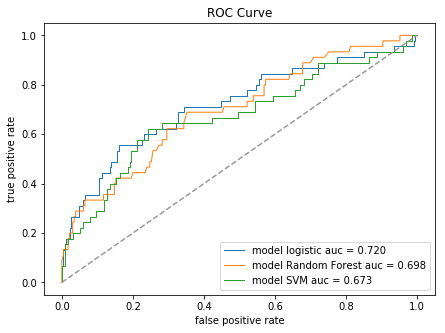

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(7, 5))

for key, value in {'logistic': pred_y_lr2, 'Random Forest': pred_y_rf, 'SVM': pred_y_svm}.items():
    fpr, tpr, thresholds = roc_curve(test_y, value, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='model %s auc = %.3f' % (key, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()